 ### Попробуйте обучить нейронную сеть на TensorFlow 2 на датасете imdb_reviews.

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds

In [18]:
# Загрузка и подготовка данных
dataset, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
train_data, test_data = dataset['train'], dataset['test']

In [34]:
for text, label in train_data.take(1):
    print(f"Review: {text.numpy()}")
    print(f"Label: {label.numpy()}\n")


Review: [[  48    2 1100 ...   13 1040 2929]
 [  10  142  132 ...    5   51   10]
 [  11    7  401 ...    0    0    0]
 ...
 [  11    7    4 ...    0    0    0]
 [  51 2268  137 ...    2  127  759]
 [  29  572   12 ...   15    2  695]]
Label: [0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1
 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 1 1 0 0]



In [19]:
# Функция для предварительной обработки данных
def preprocess(text, label):
    text = tf.strings.regex_replace(text, rb"<br\s*/?>", b" ")
    text = tf.strings.regex_replace(text, b"[^a-zA-Z']", b" ")
    return text, label


In [20]:
train_data = train_data.map(preprocess)
test_data = test_data.map(preprocess)

In [21]:
# Параметры
BUFFER_SIZE = 10000
BATCH_SIZE = 64
VOCAB_SIZE = 10000
EMBEDDING_DIM = 64
MAX_LENGTH = 200

In [22]:
# Создание текстового векторизатора
vectorize_layer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_LENGTH)

In [23]:
# Обучение векторизатора на тренировочных данных
train_text = train_data.map(lambda text, label: text)
vectorize_layer.adapt(train_text)

In [24]:
# Преобразование текстов в числовые последовательности
train_data = train_data.map(lambda text, label: (vectorize_layer(text), label))
test_data = test_data.map(lambda text, label: (vectorize_layer(text), label))

In [25]:
# Подготовка данных с использованием padded_batch
train_data = train_data.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
test_data = test_data.padded_batch(BATCH_SIZE)

In [26]:
# Создание модели с Conv1D
model = models.Sequential([
    layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


In [27]:
# Компиляция модели
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [28]:
# Обучение модели (с уменьшенным числом эпох)
history = model.fit(train_data, epochs=5, validation_data=test_data)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 65s 155ms/step - accuracy: 0.6657 - loss: 0.5747 - val_accuracy: 0.8573 - val_loss: 0.3277
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 63s 152ms/step - accuracy: 0.9023 - loss: 0.2411 - val_accuracy: 0.8628 - val_loss: 0.3254
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 79s 145ms/step - accuracy: 0.9684 - loss: 0.0991 - val_accuracy: 0.8623 - val_loss: 0.3750
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.9947 - loss: 0.0276 - val_accuracy: 0.8632 - val_loss: 0.4658
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 84s 150ms/step - accuracy: 0.9998 - loss: 0.0039 - val_accuracy: 0.8629 - val_loss: 0.5204


In [35]:
# Извлечение значений точности из истории обучения
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

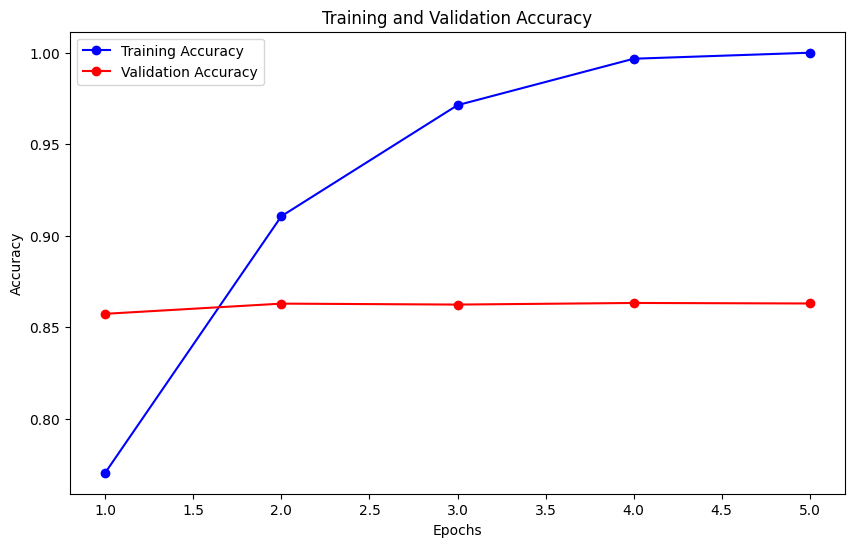

In [37]:
import matplotlib.pyplot as plt
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
# Оценка модели
loss, accuracy = model.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8605 - loss: 0.5338
Test Loss: 0.52044677734375
Test Accuracy: 0.8629199862480164


In [31]:
import pandas as pd

# Выполнение предсказаний на тестовом наборе данных
predictions = model.predict(test_data)
# Округление предсказаний для получения бинарных значений (0 или 1)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Извлечение настоящих меток из тестового набора данных
true_labels = []
for _, label in test_data:
    true_labels.extend(label.numpy())

# Создание таблицы
df = pd.DataFrame({
    'True Label': true_labels,
    'Predicted Label': predicted_labels
})

# Вывод первых 10 строк таблицы
print(df.head(20))

391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step
    True Label  Predicted Label
0            1                1
1            1                1
2            0                0
3            0                0
4            1                1
5            1                1
6            1                1
7            1                1
8            0                0
9            1                0
10           0                1
11           0                1
12           1                1
13           0                0
14           1                1
15           0                0
16           1                1
17           0                0
18           1                1
19           0                0


На семинари была отлично разобрана модель обученная на данных Fashion MNIST. Поэтому решил попробовать релизовать модель обученную на датасете imdb_reviews.
Из полученых результатов проверки на тестовой выборке был показан не плохой результат accuracy 0.86, при этом так же можно заметить, что при 2 прогоне модели через слои нейронок идет переобучение модели. В этом случае стоит сократить число эпох до 2 , чтобы снизить нагрузку на систему и увеличить скорость получения желаемого результа. Наверняка, показатель accuracy в 0.86 не максимальный, и для его увеличения можно еще "поиграть с параметрами", но на данном этапе этого достаточно.



